In [1]:
%matplotlib inline
from os.path import join

import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed


def load_ground_truth():
    with open("./data/train.txt") as f:
        ret = [float(l.strip()) for l in f.readlines()]
    return ret

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ret[n-1:] /= n
    ret[:n] = a[:n]
    return ret 

In [7]:
dp = {}

def homo_two(no1, no2):
    if (no1, no2) in dp:
        return dp[(no1, no2)] 
    img1 = cv2.imread(join("/tmp/frames/train/", f"{no1:08d}.png"), 0)          # queryImage
    img2 = cv2.imread(join("/tmp/frames/train/", f"{no2:08d}.png"), 0) 
    fet_extract = cv2.ORB_create()
    kp1, des1 = fet_extract.detectAndCompute(img1, None)
    kp2, des2 = fet_extract.detectAndCompute(img2, None)
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1,des2)
    matches = sorted(matches, key = lambda x:x.distance)[:100]
    
    keypoints1 = np.zeros((len(matches), 2))
    keypoints2 = np.zeros((len(matches), 2))
    for i, match in enumerate(matches):
        keypoints1[i, :] = kp1[match.queryIdx].pt
        keypoints2[i, :] = kp2[match.trainIdx].pt
        
    h, _ = cv2.findHomography(keypoints1, keypoints2, cv2.RANSAC)
    dp[(no1, no2)] = h
    return h

def extract1(img_no):
    hs = [
        homo_two(img_no, img_no+1).reshape(-1),
        homo_two(img_no, img_no+2).reshape(-1),
        homo_two(img_no, img_no+3).reshape(-1),
        homo_two(img_no, img_no+4).reshape(-1),
        homo_two(img_no, img_no+5).reshape(-1),
        homo_two(img_no+1, img_no+2).reshape(-1),
        homo_two(img_no+1, img_no+3).reshape(-1),
        homo_two(img_no+2, img_no+3).reshape(-1),
    ]
    return np.concatenate(hs)
ground_truth = load_ground_truth()    

def helper(i):
    return (extract1(i+1), ground_truth[i])

#ret = Parallel(n_jobs=12, verbose=5)(delayed(helper)(i+1) for i in range(18000-6))
ret = Parallel(n_jobs=12, verbose=5, prefer='threads')(delayed(helper)(i) for i in range(18000-6))
X, y = zip(*ret)
X, y = np.vstack(X), np.array(y)

ret = Parallel(n_jobs=12, verbose=5, prefer='threads')(delayed(helper)(i+1) for i in range(18000, 20400-6))
#ret = Parallel(n_jobs=12, verbose=5)(delayed(helper)(i) for i in range(19400, 20400-6))
tstX, tsty = zip(*ret)
tstX, tsty = np.vstack(tstX), np.array(tsty)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    1.3s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    3.3s
[Parallel(n_jobs=12)]: Done 264 tasks      | elapsed:    6.6s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:   10.4s
[Parallel(n_jobs=12)]: Done 624 tasks      | elapsed:   16.0s
[Parallel(n_jobs=12)]: Done 858 tasks      | elapsed:   22.1s
[Parallel(n_jobs=12)]: Done 1128 tasks      | elapsed:   29.0s
[Parallel(n_jobs=12)]: Done 1434 tasks      | elapsed:   37.5s
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:   46.6s
[Parallel(n_jobs=12)]: Done 2154 tasks      | elapsed:   56.0s
[Parallel(n_jobs=12)]: Done 2568 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 3018 tasks      | elapsed:  1.3min
[Parallel(n_jobs=12)]: Done 3504 tasks      | elapsed:  1.5min
[Parallel(n_jobs=12)]: Done 4026 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 4584 tasks    

In [80]:
%%time
alphas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]

def proc_fet(X):
    #idxs = np.concatenate([np.array([2, 5, 6, 7]) + 8*i for i in range(8)])
    #idxs = np.concatenate([np.array([6, 7]) + 8*i for i in range(8)])
    idxs = np.arange(64)
    pX = X[:, idxs]
    pX = PolynomialFeatures(degree=2).fit_transform(pX)
    return pX
pX = proc_fet(X)
ptstX = proc_fet(tstX)
regressor = RidgeCV(alphas=alphas, normalize=True,
                    fit_intercept=True, store_cv_values=False,
                    scoring='neg_mean_squared_error')

hist, edge = np.histogram(y, bins=20)
bin_id = np.searchsorted(edge[1:], y)
sample_weight = sum(bin_id) / hist[bin_id]
regressor.fit(pX, y, sample_weight=sample_weight)

print(regressor.score(pX, y))

0.171258504621
CPU times: user 53min 46s, sys: 29min 12s, total: 1h 22min 58s
Wall time: 15min 9s


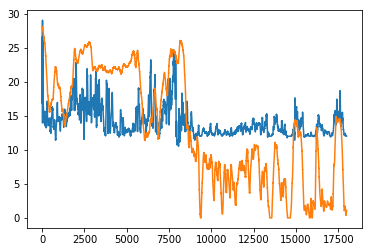

In [77]:
pred = regressor.predict(pX)
tst_pred = regressor.predict(ptstX)
plt.plot(moving_average(pred, n=30))
plt.plot(y)

In [78]:
print("train err: ", mean_squared_error(y, pred))
print("test err: ", mean_squared_error(tsty, tst_pred))
print("moving avg 5, train err: ", mean_squared_error(y, moving_average(pred, n=5)))
print("moving avg 5, test err: ", mean_squared_error(tsty, moving_average(tst_pred, n=5)))


train err:  54.5269509782
test err:  75.770796848
moving avg 5, train err:  52.9410879771
moving avg 5, test err:  75.2120165378


In [57]:
def sequence_predict(begins, X, regressor):
    pX = proc_fet(X)
    n = len(begins)
    preds = begins
    for i in range(len(X)):
        preds.append(regressor.predict([np.concatenate((pX[i], [preds[-i] for i in range(n, 0, -1)]), axis=0)])[0])
    return np.array(preds)

In [72]:
alphas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]

pX = proc_fet(X)
pX = np.hstack((pX[2:], y[:-2].reshape(-1, 1), y[1:-1].reshape(-1, 1)))
#ptstX = proc_fet(tstX)
regressor_seq = RidgeCV(alphas=alphas, normalize=True, fit_intercept=True,
                    store_cv_values=True,
                    scoring='neg_mean_squared_error').fit(pX, y[2:])
print("Score: ", regressor_seq.score(pX, y[2:]))
pred = regressor.predict(proc_fet(X))
seq_pred = sequence_predict([pred[0], pred[1]], X[2:], regressor_seq)
tst_pred = regressor.predict(proc_fet(tstX))
tst_seq_pred = sequence_predict([tst_pred[0], tst_pred[1]], tstX[2:], regressor_seq)

Score:  0.999936511575


In [64]:
pX = proc_fet(X)
pX = np.hstack((pX[1:], y[:-1].reshape(-1, 1)))
regressor_seq = RidgeCV(alphas=alphas, normalize=True, fit_intercept=True,
                        store_cv_values=True,
                        scoring='neg_mean_squared_error').fit(pX, y[1:])
print("Score: ", regressor_seq.score(pX, y[1:]))
pred = regressor.predict(proc_fet(X))
seq_pred = sequence_predict([pred[0]], X[1:], regressor_seq)
tst_pred = regressor.predict(proc_fet(tstX))
tst_seq_pred = sequence_predict([tst_pred[0]], tstX[1:], regressor_seq)

Score:  0.999952739711


train err:  50.2994046339
train err:  35.2384515208
train err:  38.8362111993
test err:  49.9907448141
test err:  35.9424298094
test err:  41.083503705


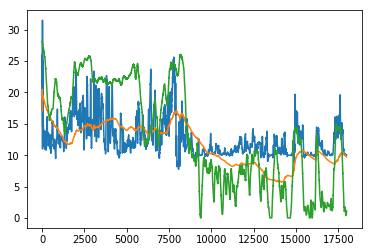

In [73]:
plt.plot(moving_average(pred, 30))
plt.plot(seq_pred)
plt.plot(y)

print("train err: ", mean_squared_error(y, pred))
print("train err: ", mean_squared_error(y, seq_pred))
print("train err: ", mean_squared_error(y, (pred + seq_pred)/2))
print("test err: ", mean_squared_error(tsty, tst_pred))
print("test err: ", mean_squared_error(tsty, tst_seq_pred))
print("test err: ", mean_squared_error(tsty, (tst_pred + tst_seq_pred)/2))